In [17]:
import numpy as np
import pandas as pd

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor,LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('max_column', 1000)
pd.set_option('max_rows', 1000)

In [19]:
DATA=pd.read_csv('NEWBI.csv')

In [20]:
DATA.head()

,aaaaa_FID,ADA,Detour Ratio,Turns,new_ID,FID_2,CRASH_TIME,DATE,DAY,LOCATION,PROBABLE_C,ROUTE,VEHICLE_CA,VEHICLE_CL,month,DATE.1,Long_x_,Lat_y_,Target,PRECTOT,RH2M,PS,T2M_RANGE,WS50M_RANGE,WS10M_RANGE,CLRSKY_SFC_SW_DWN,QV2M,ALLSKY_SFC_SW_DWN
0,109,0.000000,1.000000,1,110,0.0,1255,11-Mar-13,SUN,KM8-OOLO 1,,OGB-OYO,CAR,COMM,3,11-Mar-13,4.12324,8.027341,1,2.31,77.16,97.12,9.65,3.10,2.25,6.22,16.19,6.17
1,19,89.761842,1.019074,12,20,1.0,1255,11-Mar-13,SUN,KM8-OOLO 1,,OGB-OYO,CAR,COMM,3,11-Mar-13,4.12324,8.027341,0,2.31,77.16,97.12,9.65,3.10,2.25,6.22,16.19,6.17
2,143,80.034544,1.004572,2,144,1.0,245,11-Apr-13,MON,KM8-FLYOVER1,,OGB-ILN,BUS,COMM.,4,11-Apr-13,4.24415,8.164851,1,1.53,68.08,97.22,10.88,3.32,2.76,6.22,14.49,6.15
3,145,24.639955,1.000619,1,146,1.0,245,11-Apr-13,MON,KM8-FLYOVER1,,OGB-ILN,BUS,COMM.,4,11-Apr-13,4.24415,8.164851,0,1.53,68.08,97.22,10.88,3.32,2.76,6.22,14.49,6.15
4,158,25.598823,1.007060,3,159,1.0,245,11-Apr-13,MON,KM8-FLYOVER1,,OGB-ILN,BUS,COMM.,4,11-Apr-13,4.24415,8.164851,0,1.53,68.08,97.22,10.88,3.32,2.76,6.22,14.49,6.15


In [21]:
DATA=DATA.drop(['LOCATION','DATE','DATE.1'], axis=1)

In [22]:
DATA.head()

,aaaaa_FID,ADA,Detour Ratio,Turns,new_ID,FID_2,CRASH_TIME,DAY,PROBABLE_C,ROUTE,VEHICLE_CA,VEHICLE_CL,month,Long_x_,Lat_y_,Target,PRECTOT,RH2M,PS,T2M_RANGE,WS50M_RANGE,WS10M_RANGE,CLRSKY_SFC_SW_DWN,QV2M,ALLSKY_SFC_SW_DWN
0,109,0.000000,1.000000,1,110,0.0,1255,SUN,,OGB-OYO,CAR,COMM,3,4.12324,8.027341,1,2.31,77.16,97.12,9.65,3.10,2.25,6.22,16.19,6.17
1,19,89.761842,1.019074,12,20,1.0,1255,SUN,,OGB-OYO,CAR,COMM,3,4.12324,8.027341,0,2.31,77.16,97.12,9.65,3.10,2.25,6.22,16.19,6.17
2,143,80.034544,1.004572,2,144,1.0,245,MON,,OGB-ILN,BUS,COMM.,4,4.24415,8.164851,1,1.53,68.08,97.22,10.88,3.32,2.76,6.22,14.49,6.15
3,145,24.639955,1.000619,1,146,1.0,245,MON,,OGB-ILN,BUS,COMM.,4,4.24415,8.164851,0,1.53,68.08,97.22,10.88,3.32,2.76,6.22,14.49,6.15
4,158,25.598823,1.007060,3,159,1.0,245,MON,,OGB-ILN,BUS,COMM.,4,4.24415,8.164851,0,1.53,68.08,97.22,10.88,3.32,2.76,6.22,14.49,6.15


In [23]:
DATA['VEHICLE_CL'].nunique()

27

In [24]:
def tenure(x):
    if x == 'COMM/COMM/ COMM':
        return 'Commercial'
    if x == 'COMM/   COMM':
        return 'Commercial'
    elif x == 'COMM':
        return 'Commercial'
    elif x == 'PVT/   PVT':
        return 'Private'
    elif x == 'PVT':
        return 'Private'
    else:
        return 'both'

In [25]:
DATA['VEHICLE_CL'] = DATA['VEHICLE_CL'].apply(tenure)

In [26]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 25 columns):
aaaaa_FID            159 non-null int64
ADA                  159 non-null float64
Detour Ratio         159 non-null float64
Turns                159 non-null int64
new_ID               159 non-null int64
FID_2                155 non-null float64
CRASH_TIME           159 non-null int64
DAY                  159 non-null object
PROBABLE_C           159 non-null object
ROUTE                159 non-null object
VEHICLE_CA           159 non-null object
VEHICLE_CL           159 non-null object
month                159 non-null int64
Long_x_              159 non-null float64
Lat_y_               159 non-null float64
Target               159 non-null int64
PRECTOT              159 non-null float64
RH2M                 159 non-null float64
PS                   159 non-null float64
T2M_RANGE            159 non-null float64
WS50M_RANGE          159 non-null float64
WS10M_RANGE          159 non-n

In [27]:
from sklearn.preprocessing import LabelEncoder

for i in ["VEHICLE_CA", "ROUTE", "DAY",'PROBABLE_C','VEHICLE_CL']:
    DATA[i] = LabelEncoder().fit_transform(DATA[i])


In [28]:
X = DATA.drop(columns='Target')
y = DATA['Target']


In [29]:
#DATA=DATA.drop('DATE.1',axis=1)

In [30]:
#from datetime import datetime
#DATA['DATE'].to_datetime
#DATA['DATE'].head()

In [118]:

err=[]
y_pred_totcb=[]

fold=KFold(n_splits=5, random_state=1234)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m1 = RandomForestClassifier(
                n_estimators=50,
                criterion='gini',
                max_depth=5,
                min_samples_split=2,
                min_samples_leaf=1,
                min_weight_fraction_leaf=0.0,
                max_features='auto',
                max_leaf_nodes=None,
                min_impurity_decrease=0.0,
                min_impurity_split=None,
                bootstrap=True,
                oob_score=False,
                n_jobs=-1,
                random_state=0,
                verbose=0,
                warm_start=False,
                class_weight='balanced'
                        )
    m1.fit(X_train,y_train)
    preds = m1.predict_proba(X_test)[:,1]
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    err.append(np.sqrt(mean_squared_error(y_test,preds)))
    #p2 = m1.predict(tes)
    #y_pred_totcb.append(p2)
np.mean(err)

err:  0.41758568556988473
err:  0.4746501920320695
err:  0.5069596519257302
err:  0.4109847607062346
err:  0.4139287423578634


0.4448218065183565

In [119]:
preds.shape

(31,)

In [120]:
y_test.shape

(31,)

In [121]:
ypt = preds>0.1


print ('Test Accuracy:',accuracy_score(y_test,ypt))
print ('Test F1:',f1_score(y_test,ypt))
print ('Test Precision:',precision_score(y_test,ypt))
print ('Test AP:',average_precision_score(y_test,ypt))
print ('Test Recall:',recall_score(y_test,ypt))
print ('Test AUC:',roc_auc_score(y_test,preds))

Test Accuracy: 0.5483870967741935
Test F1: 0.7083333333333333
Test Precision: 0.5483870967741935
Test AP: 0.5483870967741935
Test Recall: 1.0
Test AUC: 0.8718487394957983


In [74]:
np.where(np.isnan(X))

(array([ 97,  99, 100, 102], dtype=int64), array([5, 5, 5, 5], dtype=int64))

In [77]:
X=pd.DataFrame(X).fillna(-9999)

In [115]:
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

testsplit_store=[]
test_store1=[]
fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=123456)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xgb = XGBClassifier(objective ='binary:logistic', 
                          #'eval_metric='RMSE'',
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8)
    xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100)
    predict = xgb.predict_proba(X_test)[:,1]
    print("err: ",np.sqrt(mean_squared_error(y_test,predict)))
    testsplit_store.append(np.sqrt(mean_squared_error(y_test,predict)))
  
    np.mean(testsplit_store)
    #pred = xgb.predict_proba(test)[:,1]
    
    #test_store1.append(pred)

[13:06:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.23810	validation_1-error:0.27273
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[100]	validation_0-error:0.10318	validation_1-error:0.33333
Stopping. Best iteration:
[2]	validation_0-error:0.20635	validation_1-error:0.21212

err:  0.49181548388007285
[13:06:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

In [37]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve

In [116]:
y_test.shape

(31,)

In [117]:
ypt = predict>0.1


print ('Test Accuracy:',accuracy_score(y_test,ypt))
print ('Test F1:',f1_score(y_test,ypt))
print ('Test Precision:',precision_score(y_test,ypt))
print ('Test AP:',average_precision_score(y_test,ypt))
print ('Test Recall:',recall_score(y_test,ypt))
print ('Test AUC:',roc_auc_score(y_test,predict))

Test Accuracy: 0.5161290322580645
Test F1: 0.6808510638297872
Test Precision: 0.5161290322580645
Test AP: 0.5161290322580645
Test Recall: 1.0
Test AUC: 0.6541666666666666


In [62]:
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

testsplit_store=[]
test_store2=[]
fold=StratifiedKFold(n_splits=10, shuffle=True, random_state=123456)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat = CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='Accuracy', reg_lambda = 370, random_seed= 10, use_best_model=True)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)],early_stopping_rounds = 30,  verbose = True)
    predict = cat.predict_proba(X_test)[:,1]
    print("err: ",np.sqrt(mean_squared_error(y_test,predict)))
    testsplit_store.append(np.sqrt(mean_squared_error(y_test,predict)))
          
          
np.mean(testsplit_store)
    #pred = cat.predict_proba(test)[:,1]
    #test_store2.append(pred)

0:	learn: 0.7323944	test: 0.5882353	best: 0.5882353 (0)	total: 9ms	remaining: 1m 30s
1:	learn: 0.7112676	test: 0.6470588	best: 0.6470588 (1)	total: 15.6ms	remaining: 1m 18s
2:	learn: 0.7042254	test: 0.6470588	best: 0.6470588 (1)	total: 23.3ms	remaining: 1m 17s
3:	learn: 0.7042254	test: 0.7647059	best: 0.7647059 (3)	total: 30.2ms	remaining: 1m 15s
4:	learn: 0.7042254	test: 0.7058824	best: 0.7647059 (3)	total: 37.9ms	remaining: 1m 15s
5:	learn: 0.7183099	test: 0.7058824	best: 0.7647059 (3)	total: 44.6ms	remaining: 1m 14s
6:	learn: 0.7253521	test: 0.7647059	best: 0.7647059 (3)	total: 52.2ms	remaining: 1m 14s
7:	learn: 0.7253521	test: 0.7647059	best: 0.7647059 (3)	total: 59.3ms	remaining: 1m 14s
8:	learn: 0.7323944	test: 0.7058824	best: 0.7647059 (3)	total: 67ms	remaining: 1m 14s
9:	learn: 0.7535211	test: 0.7647059	best: 0.7647059 (3)	total: 73.7ms	remaining: 1m 13s
10:	learn: 0.7464789	test: 0.7647059	best: 0.7647059 (3)	total: 81.4ms	remaining: 1m 13s
11:	learn: 0.7535211	test: 0.7647059

err:  0.4940283764900243
0:	learn: 0.7342657	test: 0.4375000	best: 0.4375000 (0)	total: 8.88ms	remaining: 1m 28s
1:	learn: 0.7622378	test: 0.3125000	best: 0.4375000 (0)	total: 15.3ms	remaining: 1m 16s
2:	learn: 0.7762238	test: 0.3125000	best: 0.4375000 (0)	total: 22.4ms	remaining: 1m 14s
3:	learn: 0.7832168	test: 0.3125000	best: 0.4375000 (0)	total: 29.3ms	remaining: 1m 13s
4:	learn: 0.7902098	test: 0.3125000	best: 0.4375000 (0)	total: 36.8ms	remaining: 1m 13s
5:	learn: 0.7902098	test: 0.3125000	best: 0.4375000 (0)	total: 43.4ms	remaining: 1m 12s
6:	learn: 0.7972028	test: 0.3750000	best: 0.4375000 (0)	total: 50.3ms	remaining: 1m 11s
7:	learn: 0.8041958	test: 0.3750000	best: 0.4375000 (0)	total: 57.2ms	remaining: 1m 11s
8:	learn: 0.8111888	test: 0.3750000	best: 0.4375000 (0)	total: 64.4ms	remaining: 1m 11s
9:	learn: 0.8251748	test: 0.3750000	best: 0.4375000 (0)	total: 72.8ms	remaining: 1m 12s
10:	learn: 0.8181818	test: 0.3750000	best: 0.4375000 (0)	total: 79.4ms	remaining: 1m 12s
11:	le

err:  0.499966941808677
0:	learn: 0.7342657	test: 0.6875000	best: 0.6875000 (0)	total: 9.16ms	remaining: 1m 31s
1:	learn: 0.6853147	test: 0.7500000	best: 0.7500000 (1)	total: 17ms	remaining: 1m 24s
2:	learn: 0.6853147	test: 0.7500000	best: 0.7500000 (1)	total: 25.1ms	remaining: 1m 23s
3:	learn: 0.7062937	test: 0.7500000	best: 0.7500000 (1)	total: 33.8ms	remaining: 1m 24s
4:	learn: 0.7062937	test: 0.7500000	best: 0.7500000 (1)	total: 44ms	remaining: 1m 28s
5:	learn: 0.7272727	test: 0.7500000	best: 0.7500000 (1)	total: 66.2ms	remaining: 1m 50s
6:	learn: 0.7412587	test: 0.6875000	best: 0.7500000 (1)	total: 79.9ms	remaining: 1m 54s
7:	learn: 0.7482517	test: 0.7500000	best: 0.7500000 (1)	total: 91.8ms	remaining: 1m 54s
8:	learn: 0.7482517	test: 0.6250000	best: 0.7500000 (1)	total: 103ms	remaining: 1m 54s
9:	learn: 0.7482517	test: 0.6875000	best: 0.7500000 (1)	total: 108ms	remaining: 1m 48s
10:	learn: 0.7552448	test: 0.6875000	best: 0.7500000 (1)	total: 116ms	remaining: 1m 45s
11:	learn: 0.7

err:  0.49965241909079827
0:	learn: 0.7013889	test: 0.4666667	best: 0.4666667 (0)	total: 10.5ms	remaining: 1m 44s
1:	learn: 0.7083333	test: 0.5333333	best: 0.5333333 (1)	total: 17.8ms	remaining: 1m 29s
2:	learn: 0.7083333	test: 0.5333333	best: 0.5333333 (1)	total: 26.2ms	remaining: 1m 27s
3:	learn: 0.7083333	test: 0.5333333	best: 0.5333333 (1)	total: 33.8ms	remaining: 1m 24s
4:	learn: 0.7291667	test: 0.5333333	best: 0.5333333 (1)	total: 42.1ms	remaining: 1m 24s
5:	learn: 0.7361111	test: 0.5333333	best: 0.5333333 (1)	total: 50.7ms	remaining: 1m 24s
6:	learn: 0.7430556	test: 0.5333333	best: 0.5333333 (1)	total: 58.1ms	remaining: 1m 22s
7:	learn: 0.7708333	test: 0.5333333	best: 0.5333333 (1)	total: 66.3ms	remaining: 1m 22s
8:	learn: 0.7708333	test: 0.5333333	best: 0.5333333 (1)	total: 73.9ms	remaining: 1m 22s
9:	learn: 0.7847222	test: 0.6000000	best: 0.6000000 (9)	total: 82.9ms	remaining: 1m 22s
10:	learn: 0.7847222	test: 0.5333333	best: 0.6000000 (9)	total: 94.5ms	remaining: 1m 25s
11:	l

0.4990479292732183

In [63]:
ypt = predict>0.1


print ('Test Accuracy:',accuracy_score(y_test,ypt))
print ('Test F1:',f1_score(y_test,ypt))
print ('Test Precision:',precision_score(y_test,ypt))
print ('Test AP:',average_precision_score(y_test,ypt))
print ('Test Recall:',recall_score(y_test,ypt))
print ('Test AUC:',roc_auc_score(y_test,predict))

Test Accuracy: 0.5333333333333333
Test F1: 0.6956521739130436
Test Precision: 0.5333333333333333
Test AP: 0.5333333333333333
Test Recall: 1.0
Test AUC: 0.6607142857142857


In [64]:
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

testsplit_store=[]
test_store3=[]
fold=StratifiedKFold(n_splits=10, shuffle=True, random_state=123456)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat = LGBMClassifier(objective =  'binary', 
                            metric= 'RMSE',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100,n_estimators=2000,random_seed = 10, use_best_model=True)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100)
    predict = cat.predict_proba(X_test)[:,1]
    #print("err: ",roc_auc_score(y_test, predict))
    print("err: ",np.sqrt(mean_squared_error(y_test,predict)))
    testsplit_store.append(np.sqrt(mean_squared_error(y_test,predict)))
    #pred = cat.predict_proba(test)[:,1]
    #test_store3.append(pred)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.499999	valid_1's rmse: 0.499136
Early stopping, best iteration is:
[1]	training's rmse: 0.499999	valid_1's rmse: 0.499136
err:  0.4993694753630553
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.499999	valid_1's rmse: 0.499136
Early stopping, best iteration is:
[1]	training's rmse: 0.499999	valid_1's rmse: 0.499136
err:  0.49936947536305526
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.499999	valid_1's rmse: 0.501218
Early stopping, best iteration is:
[1]	training's rmse: 0.499999	valid_1's rmse: 0.501218
err:  0.500305545059743
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.499999	valid_1's rmse: 0.501218
Early stopping, best iteration is:
[1]	training's rmse: 0.499999	valid_1's rmse: 0.501218
err:  0.500305545059743
Training until validation scores don't improve for 100 rounds
[10

In [65]:
ypt = predict>0.1


print ('Test Accuracy:',accuracy_score(y_test,ypt))
print ('Test F1:',f1_score(y_test,ypt))
print ('Test Precision:',precision_score(y_test,ypt))
print ('Test AP:',average_precision_score(y_test,ypt))
print ('Test Recall:',recall_score(y_test,ypt))
print ('Test AUC:',roc_auc_score(y_test,predict))

Test Accuracy: 0.5333333333333333
Test F1: 0.6956521739130436
Test Precision: 0.5333333333333333
Test AP: 0.5333333333333333
Test Recall: 1.0
Test AUC: 0.5


In [ ]:
#LGBMClassifier.fit(X_train,y_train, eval_metric='logloss',eval_set = [(X_train,y_train), 
                                                    #(X_test,y_test)], early_stopping_rounds = 200)

In [48]:
DATA=DATA.reset_index(drop=True)

In [52]:
features = [c for c in DATA.columns if c not in ['Target']]

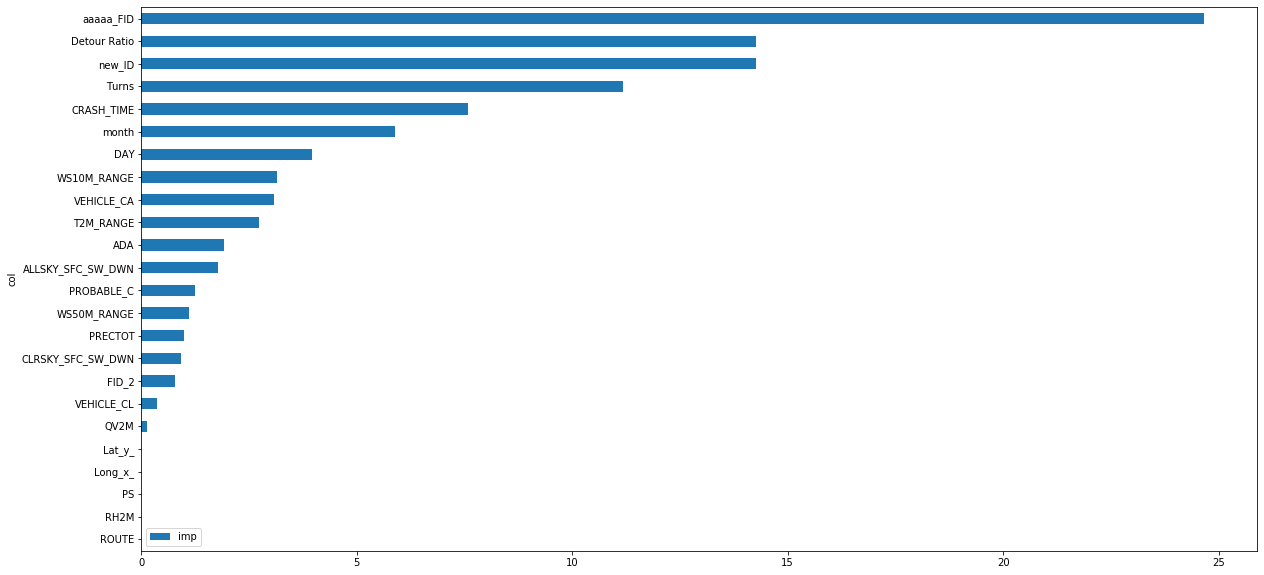

In [53]:

## Check for the feature importance 
fea_imp = pd.DataFrame({'imp':cat.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')

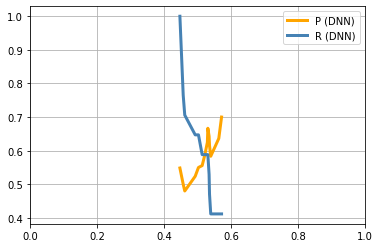

In [123]:
precision,recall,thresholds = precision_recall_curve(y_test,predict)
#precision,recall,thresholds = precision_recall_curve(y,y_pred)

plt.plot(thresholds,precision[:-1],'r-',label='P (DNN)',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (DNN)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.grid()
plt.legend()

In [66]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

<Figure size 1080x1080 with 0 Axes>

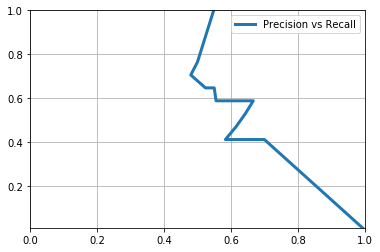

In [122]:

plt.figure(figsize=(15,15))

precision,recall,thresholds = precision_recall_curve(y_test,predict)
#precision,recall,thresholds = precision_recall_curve(y,y_pred)

fig,ax = plt.subplots()
plt.plot(precision,recall,label='Precision vs Recall',lw=3)

ax.set_xbound(lower=0.0,upper=1.0)
ax.set_ybound(lower=0.01,upper=1.0)
plt.grid()
plt.legend()

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

testsplit_store=[]
test_store3=[]
fold=KFold(n_splits=10, shuffle=True, random_state=123456)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat = RandomForestClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100,n_estimators=2000,random_seed = 10, use_best_model=True)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100)
    predict = cat.predict_proba(X_test)[:,1]
    #print("err: ",roc_auc_score(y_test, predict))
    print("err: ",np.sqrt(mean_squared_error(y_test,predict)))
    testsplit_store.append(np.sqrt(mean_squared_error(y_test,predict)))
    #pred = cat.predict_proba(test)[:,1]
    #test_store3.append(pred)

In [ ]:
DATA.columns